<a href="https://colab.research.google.com/github/Kseniya74/Prof_activity_workshop/blob/main/Text_processing_fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Классификация фейковых новостей**

##**Иморт необходимых библиотек**

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
nltk.download('stopwords')   # Скачивание стоп-слов
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import pathlib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##**Загрузка датасета**

In [42]:
#  Монтирование диска с датасетом

from google.colab import drive
drive.mount('/content/gdrive')

data_dir = "/content/gdrive/MyDrive"
data_dir = pathlib.Path(data_dir)
data_dir

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


PosixPath('/content/gdrive/MyDrive')

In [43]:
true = pd.read_csv("/content/gdrive/MyDrive/Практикум/TextProcessing/True.csv")
false = pd.read_csv("/content/gdrive/MyDrive/Практикум/TextProcessing/Fake.csv")

##**Визуализация и предобработка данных**

In [44]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [45]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [46]:
true['category'] = 1
false['category'] = 0

In [47]:
df = pd.concat([true,false]) # Объединение двух датасетов

In [48]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [49]:
df.isna().sum() # Проверка, есть ли пропуски

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [50]:
df.title.count()

44898

In [51]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

**Добавление всех текстовых данных в одну колонку, например, 'text'**

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

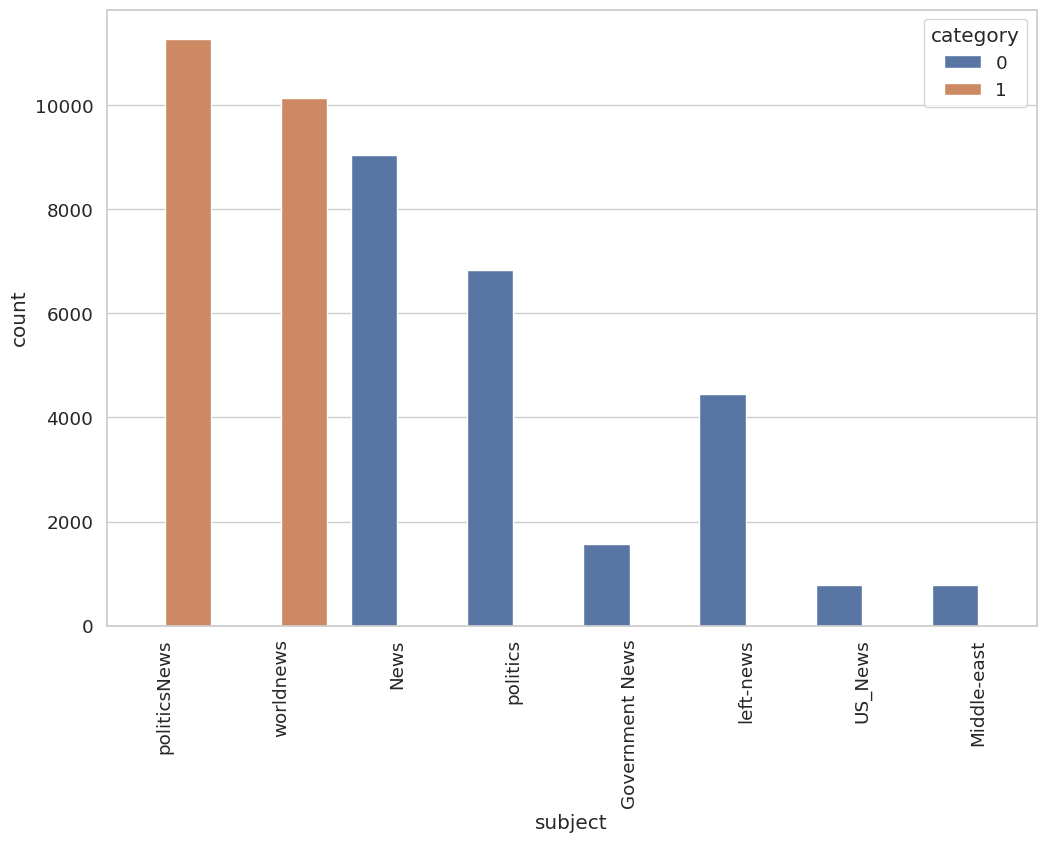

In [52]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

**Так как темы в столбце 'subject' разные для обеих категорий, удаляем его**

In [53]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

**Стоп-слова – это английские слова, которые не придают предложению особого смысла. Их можно смело игнорировать, не жертвуя смыслом предложения. Например, такие слова, как the, he, have и т. д. Загружаем список таких слов в Python.**

In [54]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

##**Чистка данных**

In [55]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Убираем квадратные скобки
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Убираем ссылки
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
# Убираем стоп-слова
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
# Убираем текст с шумами
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
# Применяем функцию для чистки колонки
df['text']=df['text'].apply(denoise_text)

<ipython-input-55-b169dabb7d22>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


###**Облако слов для настоящих новостей**

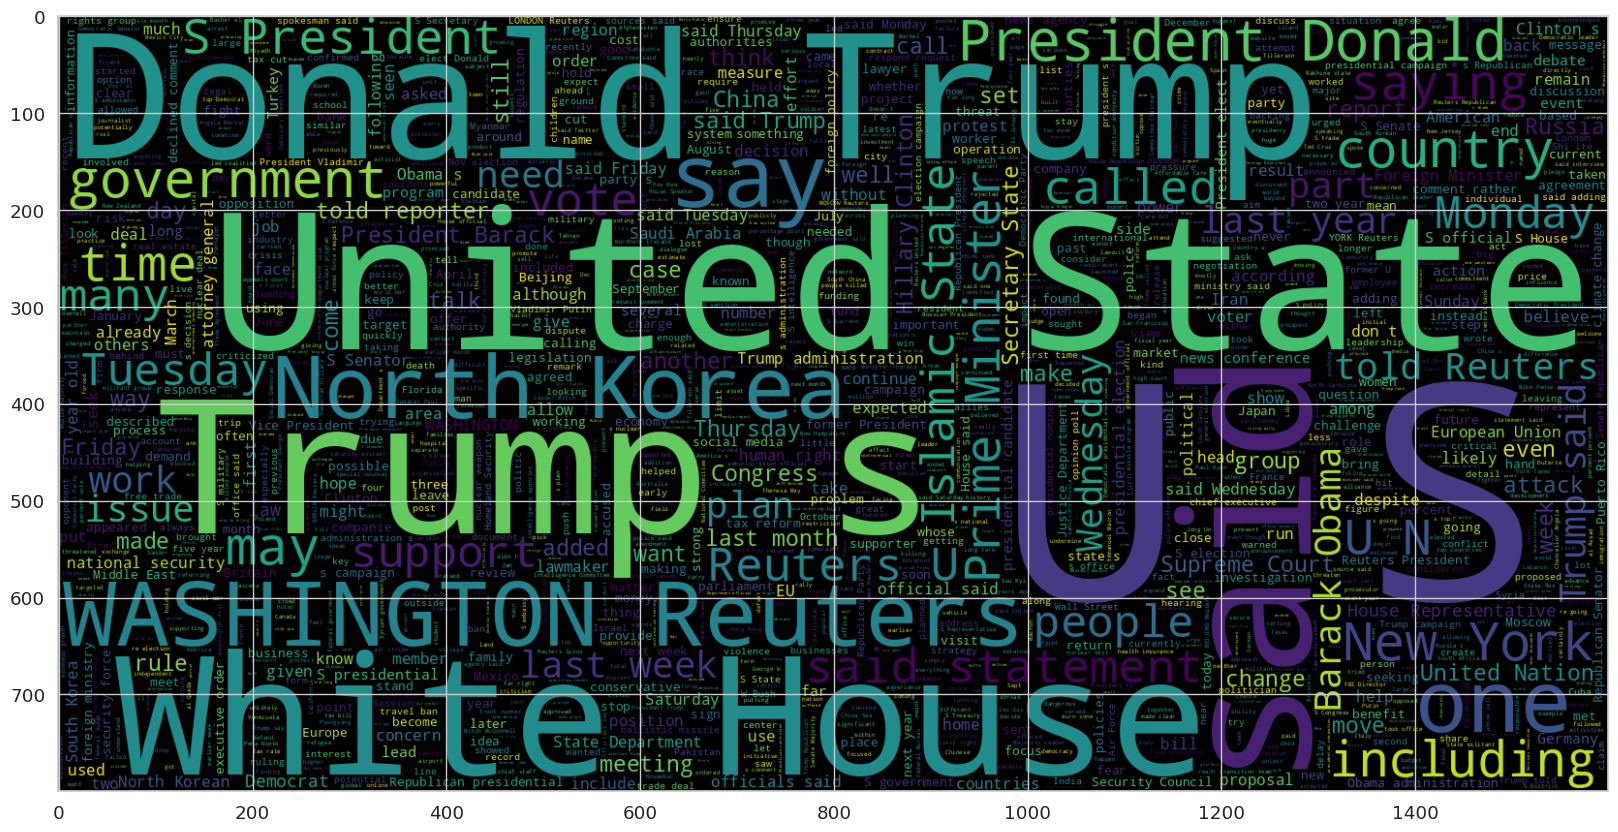

In [56]:
plt.figure(figsize = (20,20)) # Слова из обычных новостей
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

###**Облако слов для фейковых новостей**

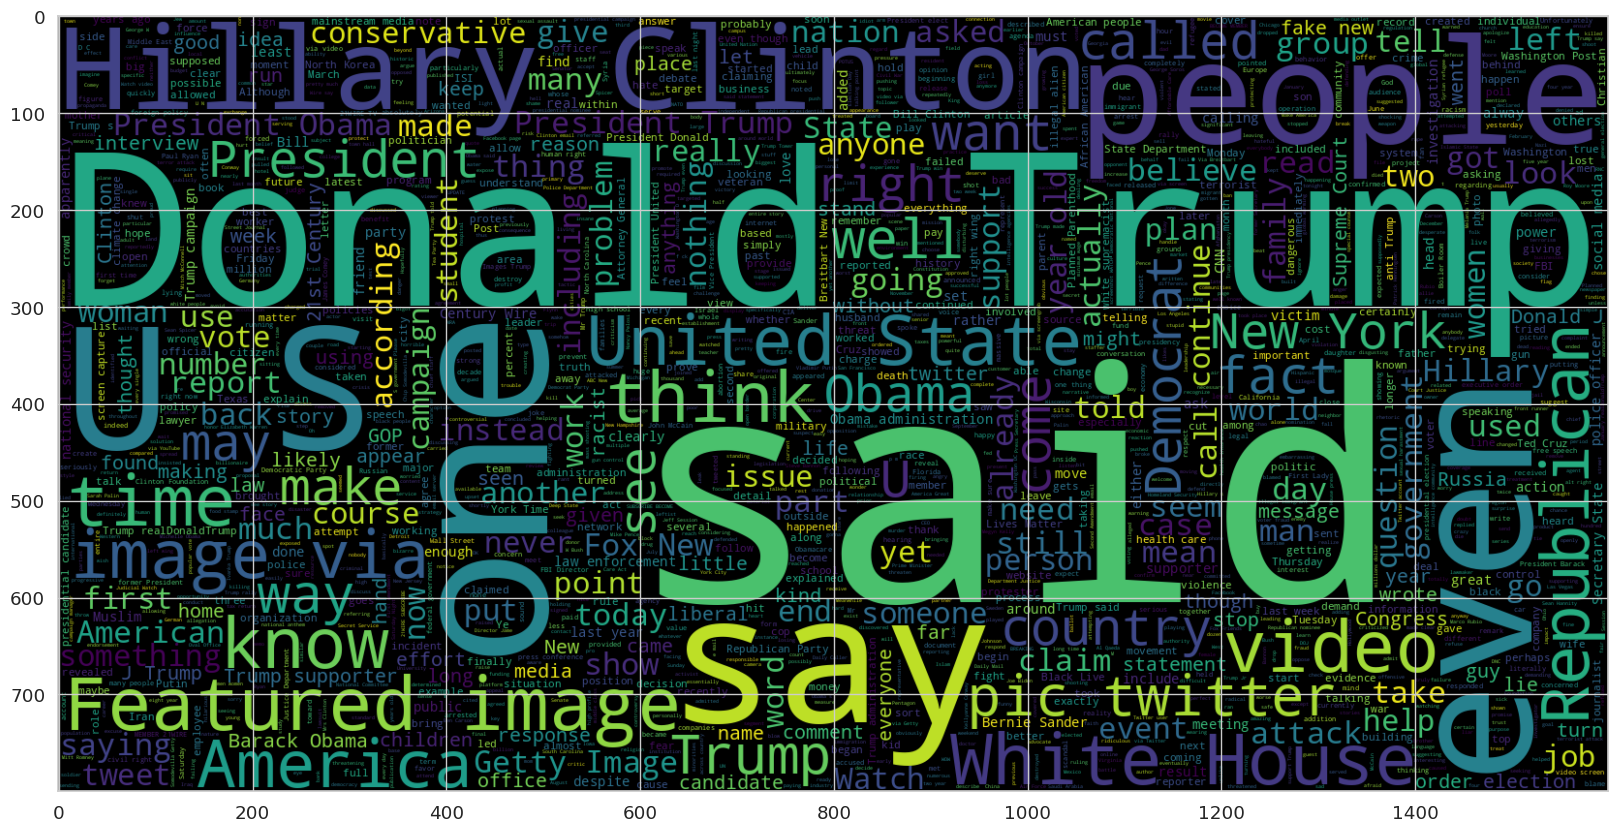

In [57]:
plt.figure(figsize = (20,20)) # Слова для фейковых новостей
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

###**Количество символов в обычных и фейковых новостях**

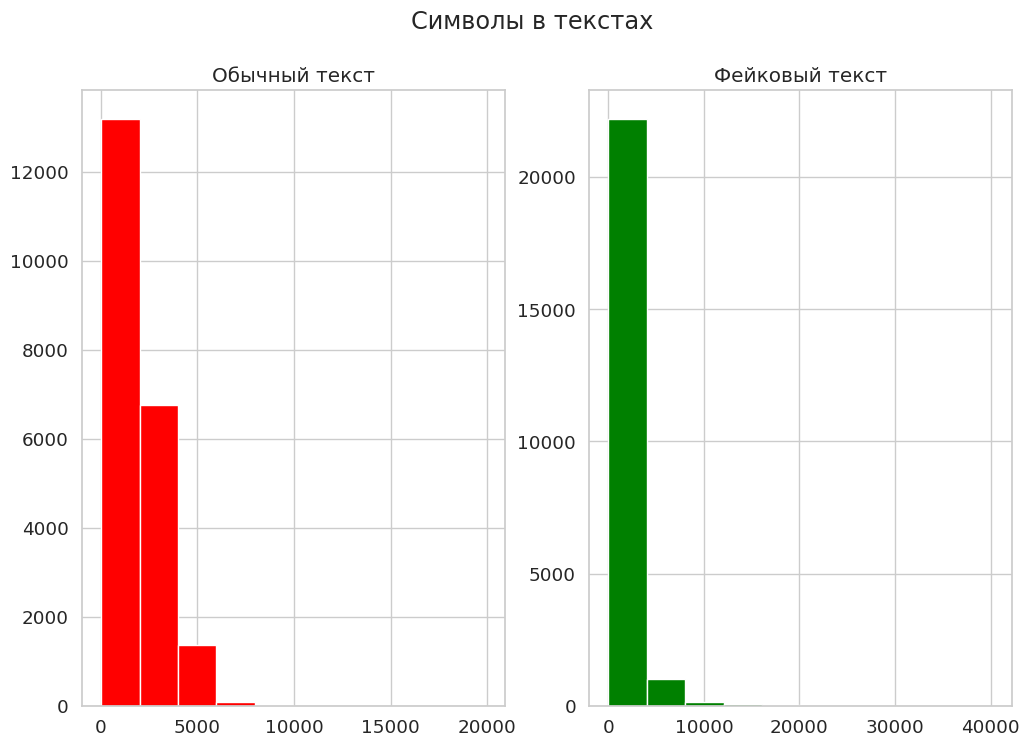

In [58]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Обычный текст')
text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Фейковый текст')
fig.suptitle('Символы в текстах')
plt.show()

**Здесь мы можем наблюдать немного отличное распределение. Текст длиной 2500 символов является наиболее распространенным в категории обычных новостей, а текст длиной около 5000 символов чаще всего встречается в категории фейковых новостей**

###**Количество слов в обычных и фейковых новостях**

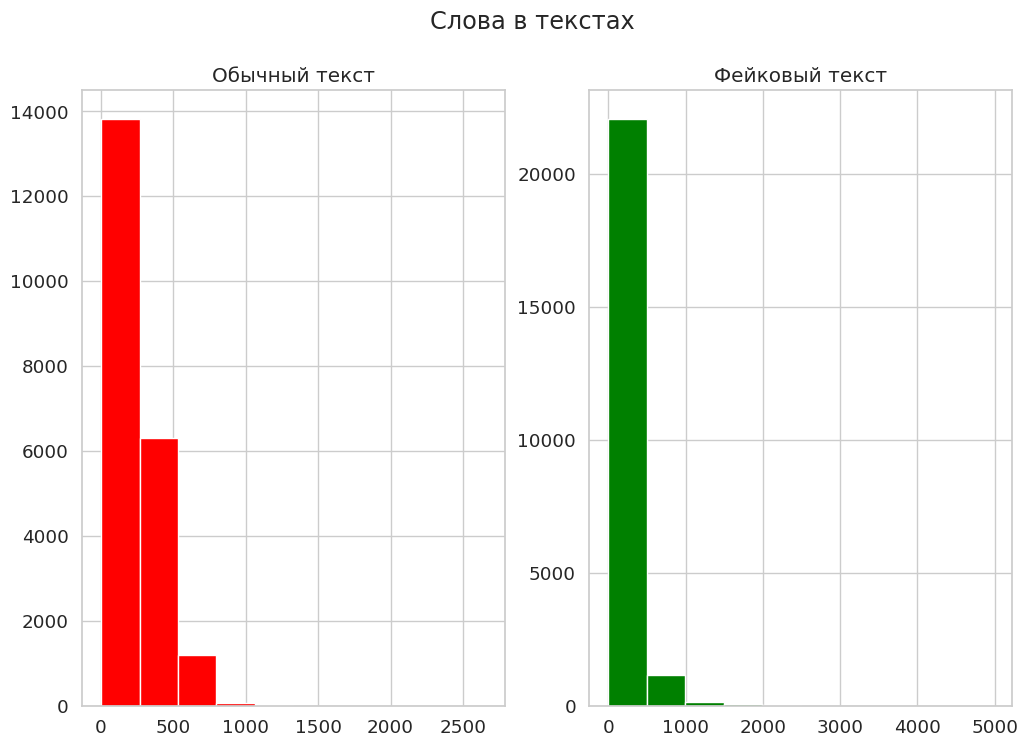

In [59]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Обычный текст')
text_len=df[df['category']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Фейковый текст')
fig.suptitle('Слова в текстах')
plt.show()

###**Средняя длина слов в обычных и фейковых новостях**

<ipython-input-60-287c34a471a2>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-60-287c34a471a2>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level f

Text(0.5, 0.98, 'Средняя длина слов в каждом тексте')

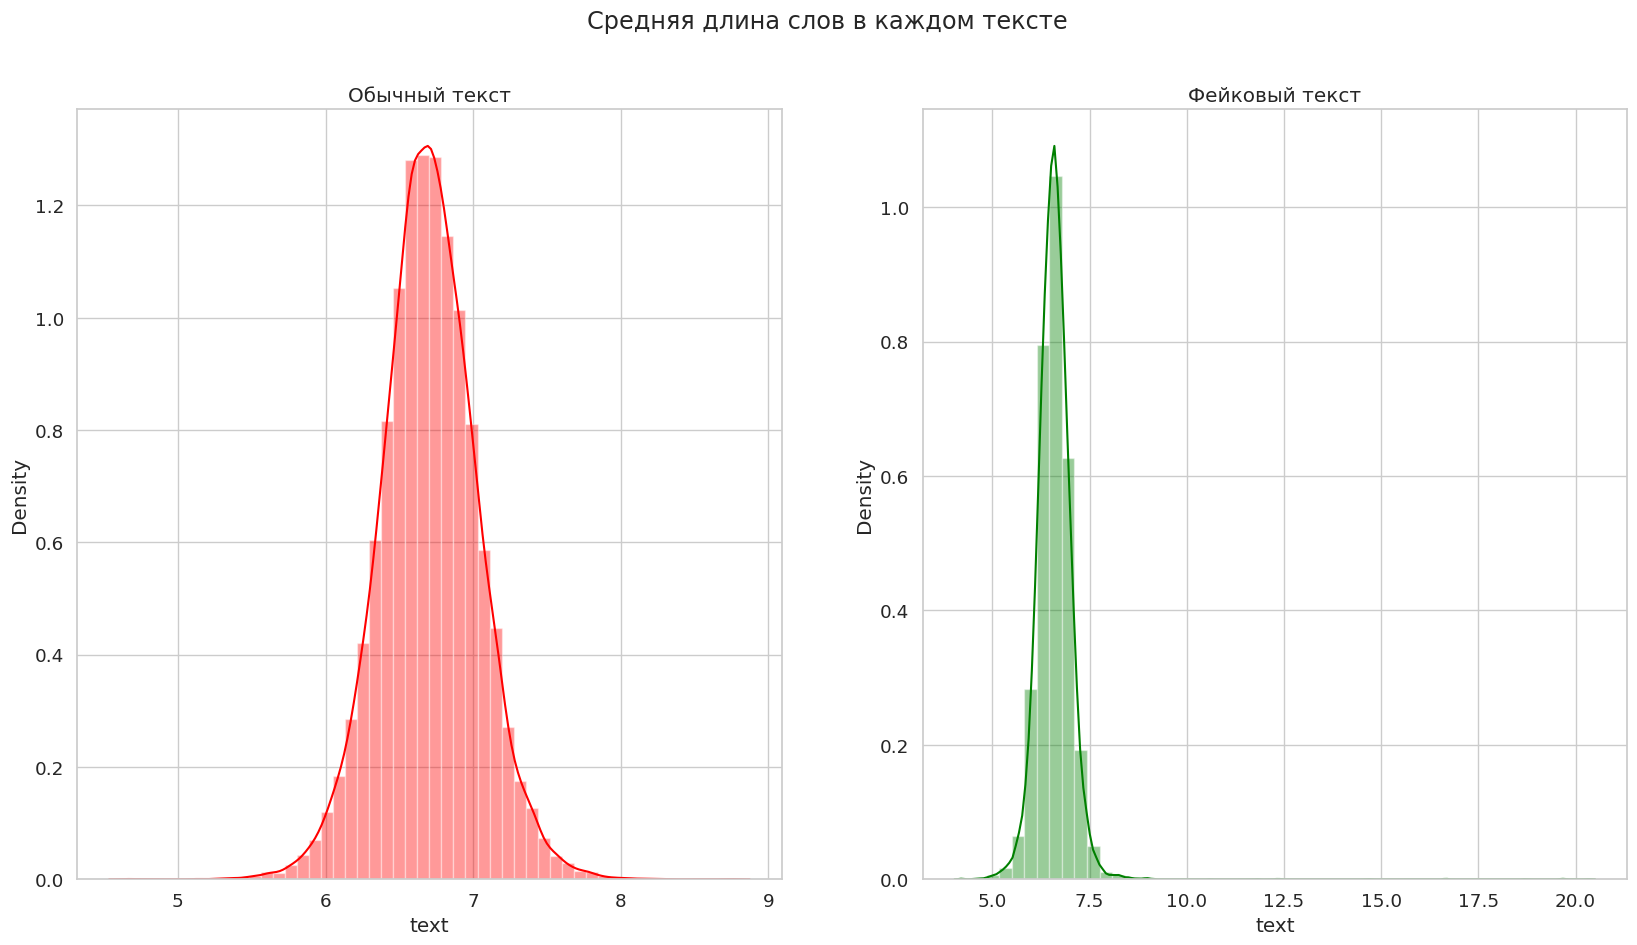

In [60]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Обычный текст')
word=df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Фейковый текст')
fig.suptitle('Средняя длина слов в каждом тексте')

In [61]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican']

In [62]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Trump': 111503,
 'said': 93162,
 'would': 54613,
 'U.S.': 50441,
 'President': 33180,
 'people': 33115,
 'also': 30325,
 'one': 29370,
 'Donald': 27795,
 'said.': 26194}

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

**Строим график для топ-10 одиночных слов**

<Axes: >

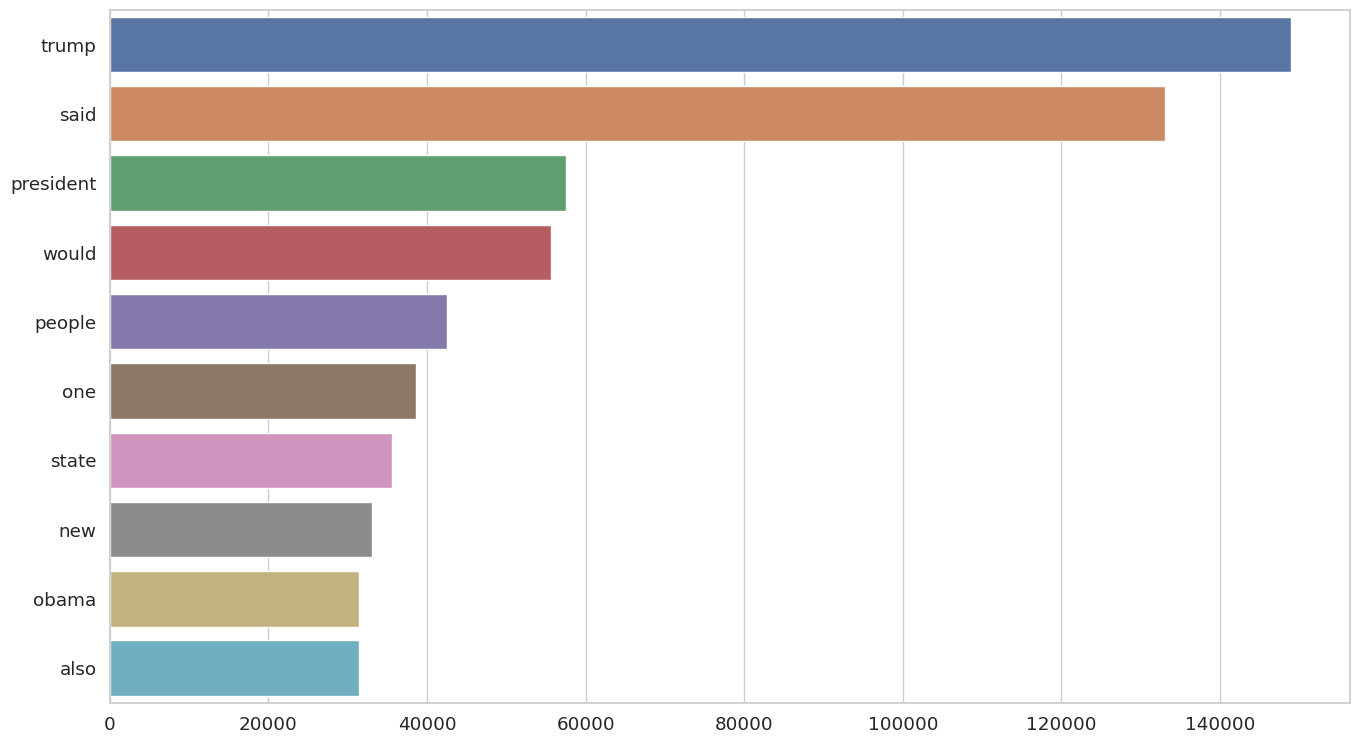

In [64]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

**Строим график для топ-10 последовательностей двух соседних слов**

<Axes: >

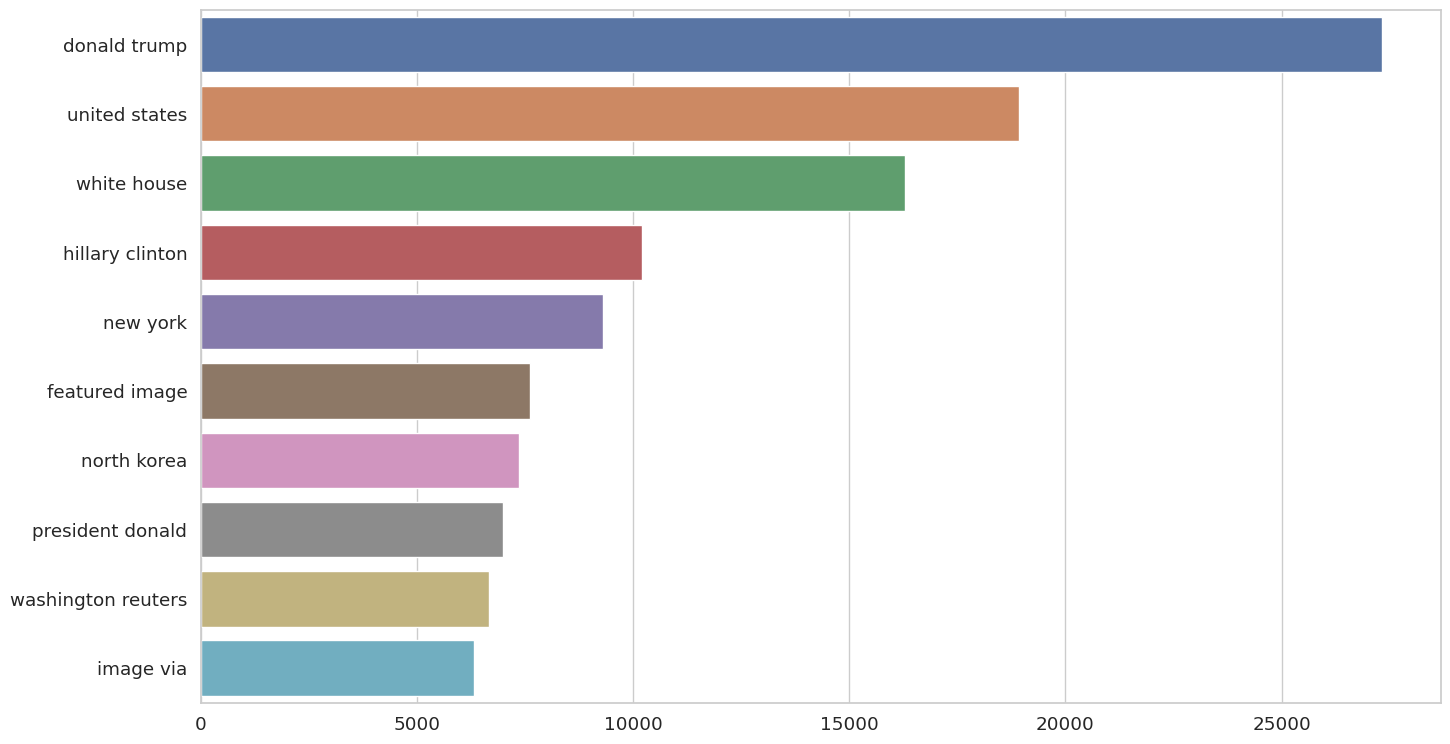

In [65]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

**Строим график для топ-10 последовательностей трёх соседних слов**

<Axes: >

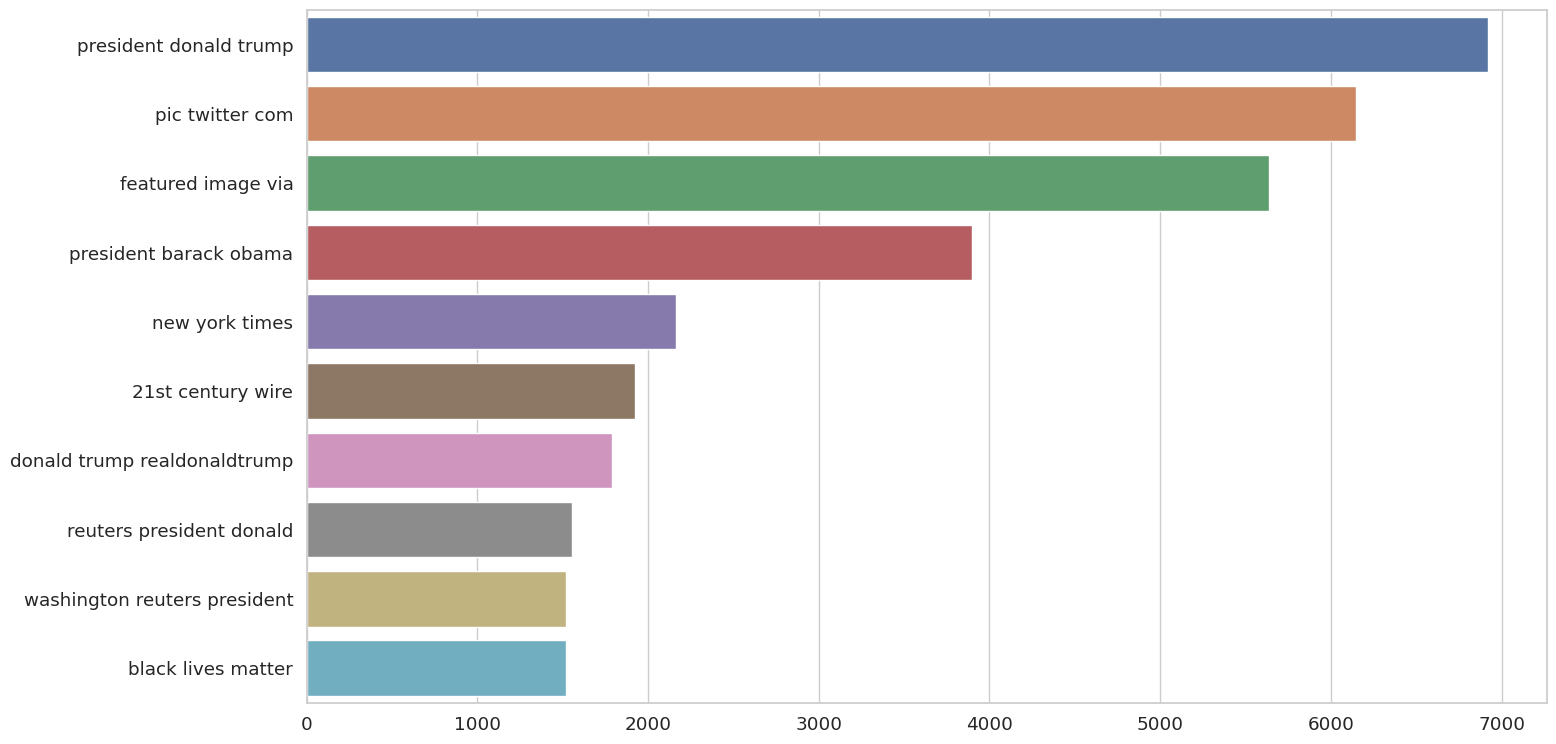

In [66]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

###**Разделяем данные на тренировочные и тестовые данные**

In [67]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [68]:
max_features = 10000
maxlen = 300

**Токенизация текста — это представление каждого слова числовым значением.**

**Сопоставление исходного слова с числом сохраняется в свойстве word_index токенизатора.**

**Tokenized применяет базовую обработку, например, меняет текущий регистр на нижний, явно устанавливая для него значение False.**

**Сохраним число всех новостей длиной до 300, добавим отступы к новостям, содержащим менее 300 слов, и обрежем длинные.**

In [69]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [70]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

**Благодаря методу GloVe из матрицы совпадений можно вывести семантические отношения между словами.**

In [71]:
EMBEDDING_FILE = '/content/gdrive/MyDrive/Практикум/TextProcessing/glove.twitter.27B.100d.txt'

In [72]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [73]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


###**Устанавливаем параметры обучения модели**

In [86]:
batch_size = 512
epochs = 5
embed_size = 100

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

##**Обучение модели**

In [87]:
model = Sequential()

model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [88]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 100)          1000000   
                                                                 
 lstm_6 (LSTM)               (None, 300, 128)          117248    
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1168769 (4.46 MB)
Trainable params: 168769 (659.25 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________________________________________________________


In [89]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/5
66/66 [==============================] - 767s 11s/step - loss: 0.2496 - accuracy: 0.9010 - val_loss: 0.1751 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 2/5
66/66 [==============================] - 713s 11s/step - loss: 0.0954 - accuracy: 0.9646 - val_loss: 0.0713 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 3/5
66/66 [==============================] - 745s 11s/step - loss: 0.0905 - accuracy: 0.9669 - val_loss: 0.0520 - val_accuracy: 0.9840 - lr: 0.0010
Epoch 4/5
66/66 [==============================] - 749s 11s/step - loss: 0.0600 - accuracy: 0.9794 - val_loss: 0.1778 - val_accuracy: 0.9260 - lr: 0.0010
Epoch 5/5
66/66 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.9679
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
66/66 [==============================] - 733s 11s/step - loss: 0.0899 - accuracy: 0.9679 - val_loss: 0.0647 - val_accuracy: 0.9779 - lr: 0.0010


##**Оценка модели**

In [90]:
print("Точность тренировочной модели - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Точность тестовой модели - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 226s 215ms/step - loss: 0.0538 - accuracy: 0.9809
Точность тренировочной модели -  98.09045791625977 %
351/351 [==============================] - 73s 208ms/step - loss: 0.0647 - accuracy: 0.9779
Точность тестовой модели -  97.79064655303955 %


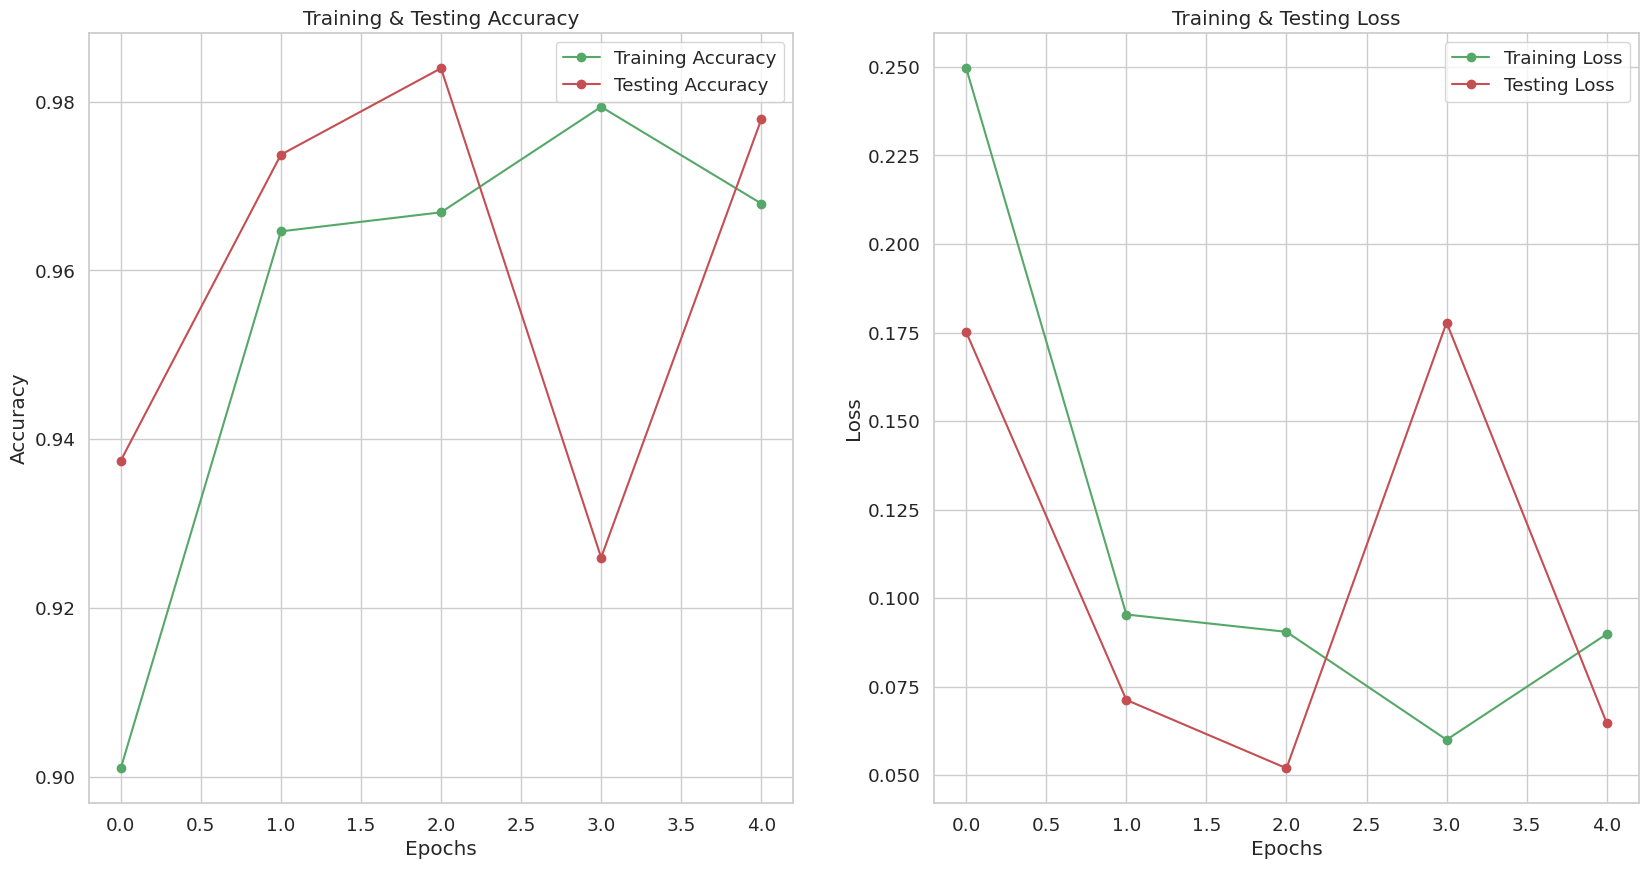

In [92]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()